RBF and MMDLoss classes are copied from https://github.com/yiftachbeer/mmd_loss_pytorch with some changes
Some inspiration from https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy

In [1]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as trans

Define RBF kernel and MMD loss functions:

In [2]:
class RBF(nn.Module):

    def __init__(self, bandwidth=None): #bandwidth = sigma
        super().__init__()
        self.bandwidth_multipliers = torch.tensor([0.5, 1, 5, 10, 20, 40], dtype = torch.float32)
        self.bandwidth = bandwidth

    def get_bandwidth(self): #if we want to scale the bandwiths
        if self.bandwidth is None:
            return 1
        return self.bandwidth

    def forward(self, X): #calculates the RBF kernel between each column in X
        L2_distances = torch.cdist(X, X) ** 2 
        return torch.exp(-0.5 * L2_distances[None, ...] / ((self.get_bandwidth() * self.bandwidth_multipliers)**2)[:, None, None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)
        #dim 0 is the bandwidth dimension : the function returns sum of kernels with different bandwiths defined by self.bandwith_multipliers
        #returns 0 on the diagonal line : dont care for kernel between data point and itself
    
class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y): #calculates the unbiased empirical MMD between X and Y
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        Y_size = Y.shape[0]
        XX = K[:X_size, :X_size].sum() / (X_size**2-X_size)
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].sum() / (Y_size**2-Y_size)
        return XX - 2 * XY + YY

Parameters:

In [3]:
N_batch = 500 #training batch size
N_input = 50 #dimension of uniformly sampled model input
N_epochs = 50 #trainig iterations

Load MNIST data:

In [4]:
#training data
trainds = torchvision.datasets.MNIST(root='./data', 
                                          train=True, 
                                          transform=trans.ToTensor(),  
                                          download=True)
#training data loader
trainldr = torch.utils.data.DataLoader(dataset=trainds, 
                                           batch_size=N_batch, 
                                           shuffle=True)

Print first four images in the training data:

60000


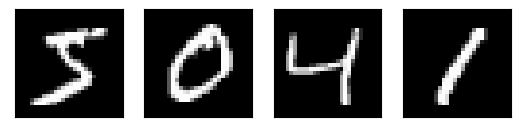

In [5]:
print(len(trainds))

plt.gray()
for r in range(4):
    ax = plt.subplot(1, 4, r+1)
    img = trainds[r][0]
    plt.imshow(img.detach().reshape(28,28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Define model:

In [6]:
class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(N_input, 1000)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(1000, 500)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(500, 500)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(500, 1000)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(1000, 28*28)
        self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.act_output(self.output(x))
        return x
    
model = network()

loss_fn = MMDLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

Train model:

In [7]:
np.random.seed(123)
torch.manual_seed(123)

#training loop
for epoch in range(N_epochs):
    for idx, (x, lbls) in enumerate(trainldr): #lbls are the digits
        x = x.reshape(-1, 28*28) #real data

        x_input = np.random.uniform(-0.5,0.5,N_batch*N_input)
        x_input = torch.tensor(x_input, dtype=torch.float32).reshape(N_batch, N_input) #model inputs

        x_output = model(x_input) #generated data

        loss = loss_fn(x, x_output)
        optimizer.zero_grad() #reset gradient
        loss.backward() #backpropagation
        optimizer.step() #optimizer iteration
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.08952784538269043
Finished epoch 1, latest loss 0.06420159339904785
Finished epoch 2, latest loss 0.057439565658569336
Finished epoch 3, latest loss 0.04259490966796875
Finished epoch 4, latest loss 0.04495716094970703
Finished epoch 5, latest loss 0.03728961944580078
Finished epoch 6, latest loss 0.02919769287109375
Finished epoch 7, latest loss 0.0289456844329834
Finished epoch 8, latest loss 0.02544856071472168
Finished epoch 9, latest loss 0.021715641021728516
Finished epoch 10, latest loss 0.017279386520385742
Finished epoch 11, latest loss 0.012683868408203125
Finished epoch 12, latest loss 0.010999679565429688
Finished epoch 13, latest loss 0.01089930534362793
Finished epoch 14, latest loss 0.012431859970092773
Finished epoch 15, latest loss 0.010688304901123047
Finished epoch 16, latest loss 0.013258934020996094
Finished epoch 17, latest loss 0.00896763801574707
Finished epoch 18, latest loss 0.009181737899780273
Finished epoch 19, latest loss 0.

Visualize model outputs:

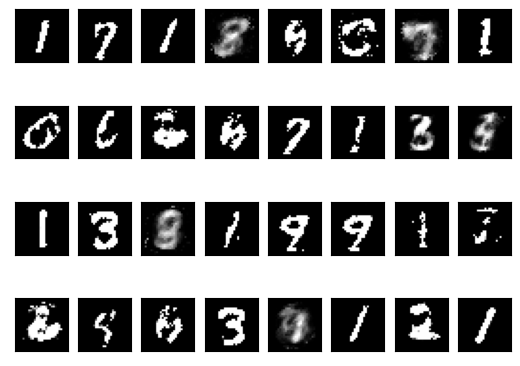

In [8]:
np.random.seed(0)

noises = [] #store for next code cell
plt.gray()
for r in range(4):
  for c in range(8):
    ax = plt.subplot(4, 8, r * 8 + c + 1)
    noise = np.random.uniform(-0.5,0.5,N_input)
    noise = torch.tensor(noise, dtype=torch.float32).reshape(1,-1) #random model inputs
    with torch.no_grad(): #do not update gradient
      test = model(noise)
    plt.imshow(test.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    noises.append(noise)
plt.show()

Nearest neighbours to make sure model doesnt simply copy training data:

tensor([[3.1085]])
tensor([[4.6509]])
tensor([[2.9711]])
tensor([[5.2714]])


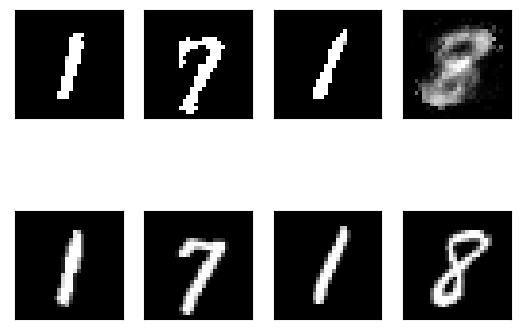

In [9]:
for i in range(4): #first four images from previous test data
    ax = plt.subplot(2, 4, i+1)
    with torch.no_grad():
        test = model(noises[i])
    plt.imshow(test.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    smallest = 0 #index such that euclidean distance between image and train image is smallest
    dist = float('inf') #smallest distance
    #search for nearest neighbour in training data:
    for j in range(len(trainds)):
        dist_new = torch.cdist(test,trainds[j][0].reshape(-1,28*28))
        if dist_new < dist: 
            dist = dist_new
            smallest = j
    ax = plt.subplot(2, 4, 5+i)
    plt.imshow(trainds[smallest][0].detach().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(dist)
plt.show()